# Regression Model Selection

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold

from modeling import split_data, model_results, plot_learning_curves, residuals_plot

%matplotlib inline

In [2]:
# oull in all clean csv files and concat them into one dataframe
df15_16 = pd.read_csv('data/legacy_runners_15-16.csv')
df15_16.drop('Unnamed: 0', inplace=True, axis=1)
df16_17 = pd.read_csv('data/legacy_runners_16-17.csv')
df16_17.drop('Unnamed: 0', inplace=True, axis=1)
df17_18 = pd.read_csv('data/legacy_runners_17-18.csv')
df17_18.drop('Unnamed: 0', inplace=True, axis=1)
df_all = pd.concat([df15_16, df16_17, df17_18])

print(df_all.shape)
df_all.head()

(13651, 13)


,Bib,Name,Age,overall_rank,gender_rank,division_rank,pace_rate,temp,humidity,wind,Gender_F,Gender_M,finish_time
0,3,"Desisa, Lelisa",25,0.000038,0.000069,0.000167,0.95,44,0.89,16,0,1,8012.0
1,4,"Tsegay, Yemane Adhane",30,0.000075,0.000137,0.000333,1.00,44,0.89,16,0,1,8042.0
2,10,"Korir, Wesley",32,0.000188,0.000343,0.000833,1.74,44,0.89,16,0,1,8045.0
3,78,"Mercier, Christian",40,0.001053,0.001920,0.000948,2.56,44,0.89,16,0,1,9270.0
4,1,"Deba, Buzunesh",27,0.001278,0.000250,0.000500,-0.37,44,0.89,16,1,0,9236.0


In [3]:
# storing the results of the models for visualizing later
models = ['LinearRegression',
        'LinearRegressionCV',
        'SGDRegressor_NoPenalty',
        'SGDRegressor_NoPenalty_Limit_X',
        'SGDRegressor_NoPenalty_Scaled',
        'SGDRegressor_LASSO',
        'SGDRegressor_RIDGE']

r2_results = []
rmse_results = []
minutes = []


## Simple Linear Regression

Results:
R^2: 0.663361068190382 RMSE: 1426.3454771997237 (Minutes: 23.772424619995395)


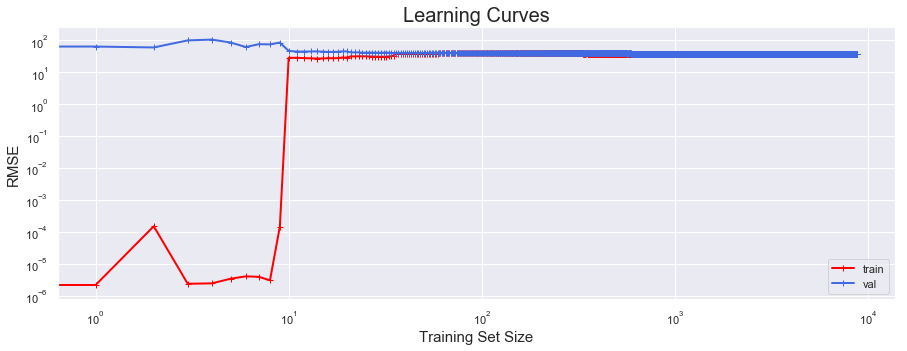

In [4]:
X_cols = ['Bib', 'Age', 'overall_rank', 'gender_rank', 'division_rank', 
          'pace_rate', 'temp', 'humidity', 'wind', 'Gender_F', 'Gender_M']

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)

linreg_model = LinearRegression(fit_intercept=False)
r2_squared, RMSE, residuals, predictions = model_results(linreg_model, X_train, y_train, X_val, y_val)
r2_results.append(round(r2_squared, 2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

print('Results:')
print(f'R^2: {r2_squared}', f'RMSE: {RMSE}', f'(Minutes: {RMSE/60})')
plot_learning_curves(linreg_model, X_train, y_train, X_val, y_val);

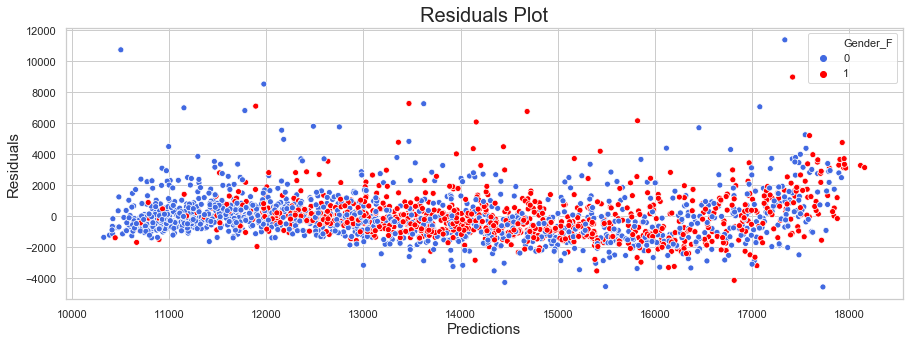

In [5]:
residuals_plot(predictions, residuals.values, X_val)

## Simple Linear Regression w/Cross Validation

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
X, y = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])

lin_reg = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 100)
r2_mean = np.mean(cross_val_score(lin_reg, X, y, cv=kf, scoring='r2'))
print('R^2: ', r2_mean)
nmse = np.mean(cross_val_score(lin_reg, X, y, cv=kf, scoring='neg_mean_squared_error'))
RMSE = np.sqrt(-nmse)
print('RMSE: ', RMSE, f'--> (Minutes {np.sqrt(-nmse)/60})')

r2_results.append(round(r2_mean,2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

R^2:  0.6809468874872453
RMSE:  1383.4175680411736 --> (Minutes 23.056959467352893)


## Stochastic Gradient Descent (SGD)

Defaults for reference
```
SGDRegressor(loss='squared_loss', 
             penalty='l2', 
             alpha=0.0001, 
             l1_ratio=0.15, 
             fit_intercept=True, 
             max_iter=None, 
             tol=None, 
             shuffle=True, 
             verbose=0, 
             epsilon=0.1, 
             random_state=None, 
             learning_rate='invscaling', 
             eta0=0.01, 
             power_t=0.25, 
             warm_start=False, 
             average=False, 
             n_iter=None)
```             
Help here: http://sdsawtelle.github.io/blog/output/week2-andrew-ng-machine-learning-with-python.html

**SGD No Penalty**

Results:
R^2: -1.828885615612907e+27 RMSE: 1.0513221908005e+17 Minutes: 1752203651334166.8


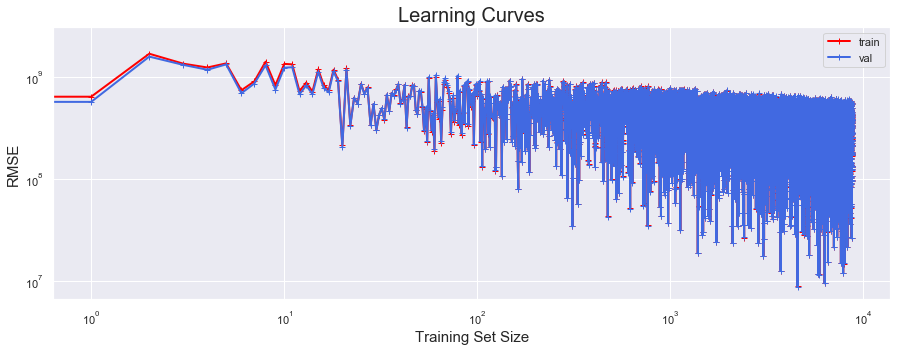

In [7]:
X_cols = ['Bib', 'Age', 'overall_rank', 'gender_rank', 'division_rank', 
          'pace_rate', 'temp', 'humidity', 'wind', 'Gender_F', 'Gender_M']

sdg_reg = SGDRegressor(random_state=11, penalty=None)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
r2_squared, RMSE, residuals, predictions = model_results(sdg_reg, X_train, y_train.values.ravel(), 
                                                         X_val, y_val.values.ravel())
r2_results.append(round(r2_squared, 2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

print('Results:')
print(f'R^2: {r2_squared}', f'RMSE: {RMSE}', f'Minutes: {RMSE/60}')
plot_learning_curves(sdg_reg, X_train, y_train.values.ravel(), X_val, y_val);

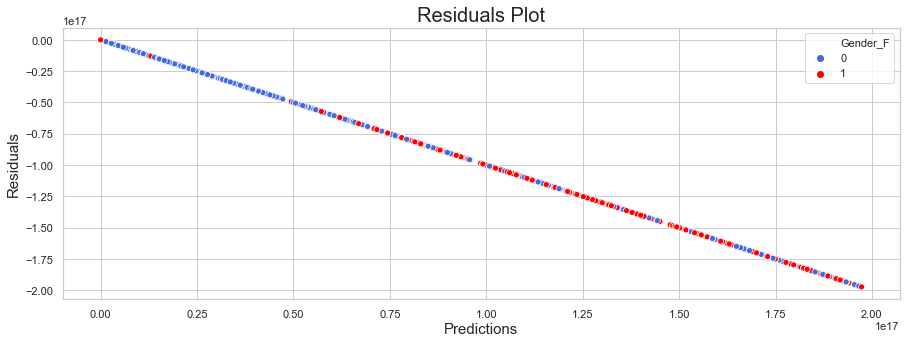

In [8]:
residuals_plot(predictions, residuals, X_val)

**SGD No Penalty - Limited Features**

In [ ]:
# def plot_learning_curves(model, X_train, y_train, X_val, y_val):
#     '''Graph learning curves.'''
#     train_errors, val_errors = [], []
#     for m in range(1, len(X_train)):
#         model.fit(X_train[:m], y_train[:m])
#         y_train_predict = model.predict(X_train[:m])
#         y_val_predict = model.predict(X_val)
#         train_errors.append(np.sqrt(mean_squared_error(y_train_predict, y_train[:m])))
#         val_errors.append(np.sqrt(mean_squared_error(y_val_predict, y_val)))
#     sns.set(style="darkgrid")
#     plt.figure(num=1, figsize=(8, 5))
#     plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train', color='red', )
#     plt.plot(np.sqrt(val_errors), 'r-+', linewidth=2, label='val', color='royalblue')
#     plt.title('Learning Curves', size=20)
#     plt.xlabel('Training Set Size', size=15)
#     plt.ylabel('RMSE', size=15)
#     plt.legend()
#     plt.xscale('log')
#     plt.yscale('log');

Results:
R^2: 0.6342263846022946 RMSE: 1486.7869716170444 Minutes: 24.779782860284072


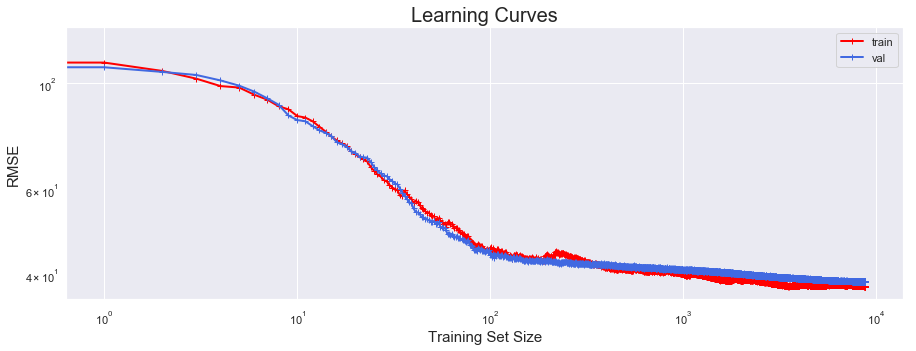

In [9]:
X_cols = ['overall_rank', 'humidity', 'Gender_M', 'Gender_F', 'gender_rank', 'division_rank']

sdg_reg = SGDRegressor(random_state=11, penalty=None)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
r2_squared, RMSE, residuals, predictions = model_results(sdg_reg, X_train, y_train.values.ravel(), 
                                                         X_val, y_val.values.ravel())
r2_results.append(round(r2_squared, 2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

print('Results:')
print(f'R^2: {r2_squared}', f'RMSE: {RMSE}', f'Minutes: {RMSE/60}')
plot_learning_curves(sdg_reg, X_train, y_train.values.ravel(), X_val, y_val);

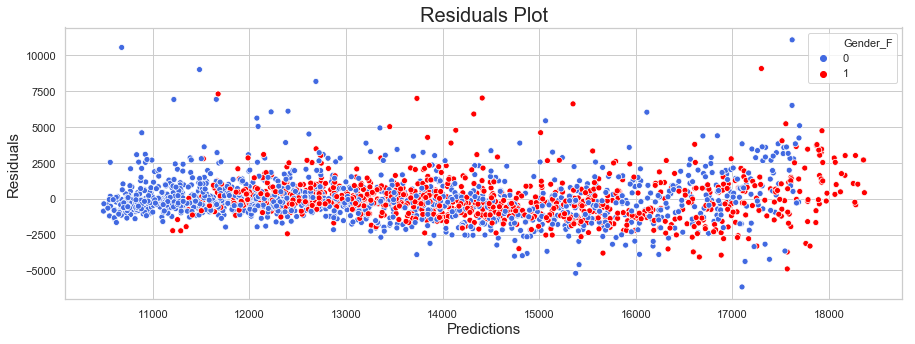

In [11]:
residuals_plot(predictions, residuals, X_val)

**SGD No Penalty - with Scaling**

Results:
R^2: 0.6478634498207182 RMSE: 1458.8079181367252 Minutes: 24.313465302278754


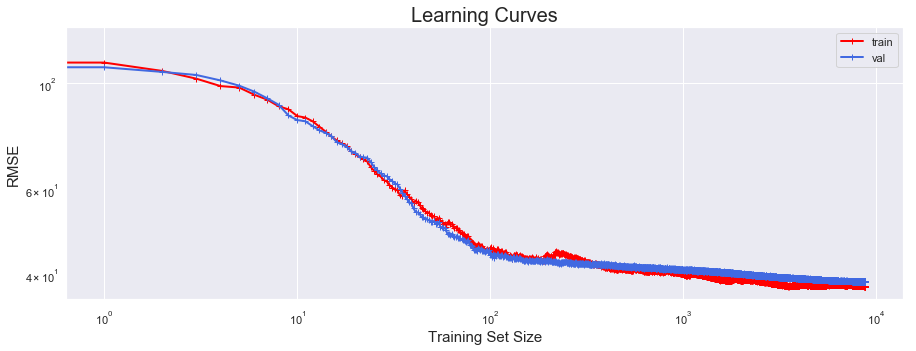

In [12]:
#scaler = StandardScaler()
#scaler.fit(X)  # Train the transformer object so it knows what means and variances to use
#X_transformed = scaler.transform(X)  # transform your training data in preparation for ML algorithm

X_cols = ['overall_rank', 'humidity', 'Gender_M', 'Gender_F', 'gender_rank', 'division_rank']
sdg_reg = SGDRegressor(random_state=11, penalty=None)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
# Fit to data and predict using pipelined scaling and SGDRegressor
std_sdg_reg = make_pipeline(StandardScaler(), sdg_reg)        
r2_squared, RMSE, residuals, predictions = model_results(std_sdg_reg, X_train, y_train.values.ravel(), 
                                                         X_val, y_val.values.ravel())
r2_results.append(round(r2_squared, 2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

print('Results:')
print(f'R^2: {r2_squared}', f'RMSE: {RMSE}', f'Minutes: {RMSE/60}')
plot_learning_curves(sdg_reg, X_train, y_train.values.ravel(), X_val, y_val);


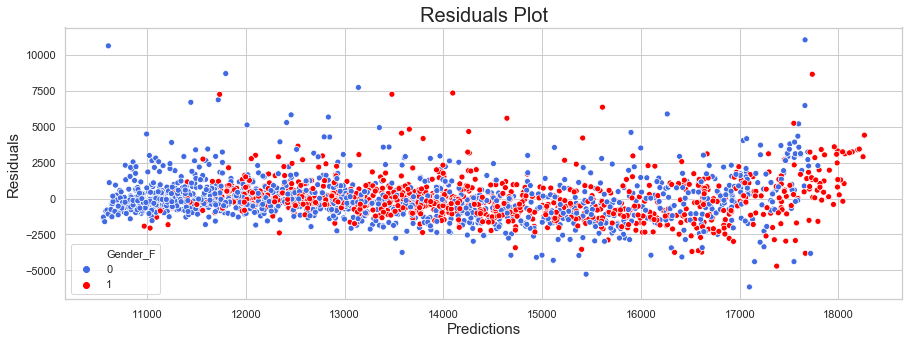

In [14]:
residuals_plot(predictions, residuals, X_val)

**SGD With Scaling and Lasso Penalty**

Results:
R^2: 0.6455733119251128, RMSE: 1463.5439459707966, (Minutes: 24.392399099513277)


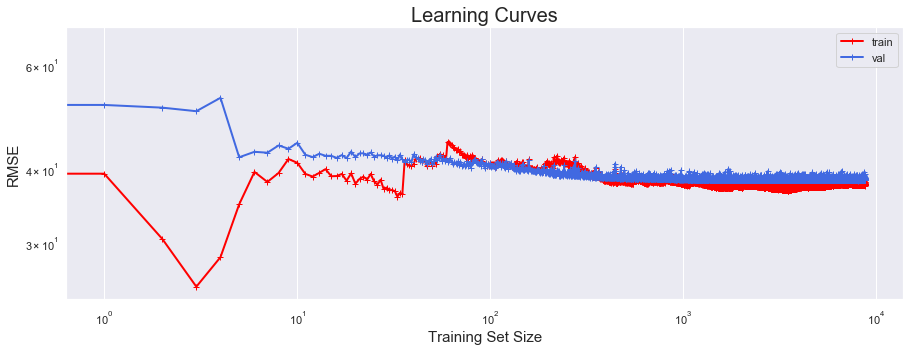

In [15]:
X_cols = ['overall_rank', 'humidity', 'Gender_M', 'Gender_F', 'gender_rank', 'division_rank']

sdg_reg = SGDRegressor(random_state=11, 
                       penalty='l1', 
                       learning_rate='invscaling', 
                       alpha = 0.001, 
                       eta0=0.1)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
# Fit to data and predict using pipelined scaling and SGDRegressor.
std_sdg_reg = make_pipeline(StandardScaler(), sdg_reg)      
r2_squared, RMSE, residuals, predictions = model_results(sdg_reg, X_train, y_train.values.ravel(), 
                                                         X_val, y_val.values.ravel())
r2_results.append(round(r2_squared, 2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

print('Results:')
print(f'R^2: {r2_squared},', f'RMSE: {RMSE},', f'(Minutes: {RMSE/60})')
plot_learning_curves(sdg_reg, X_train, y_train.values.ravel(), X_val, y_val);

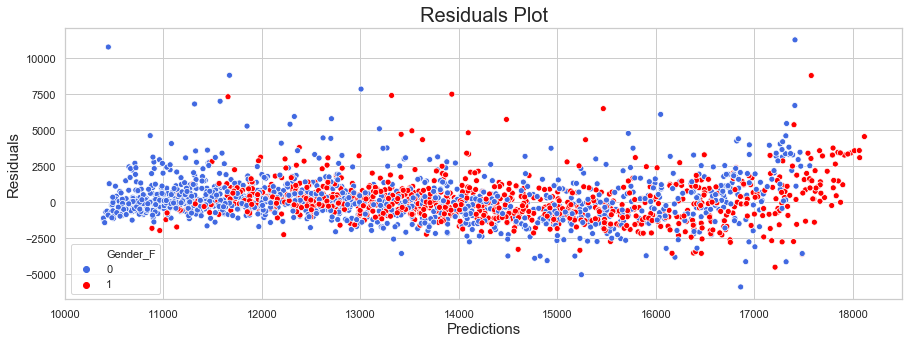

In [16]:
residuals_plot(predictions, residuals, X_val)

**SGD With Scaling and Ridge Penalty**

Results:
R^2: 0.3145937146077755 RMSE: 2035.2445510277792 Minutes: 33.92074251712965


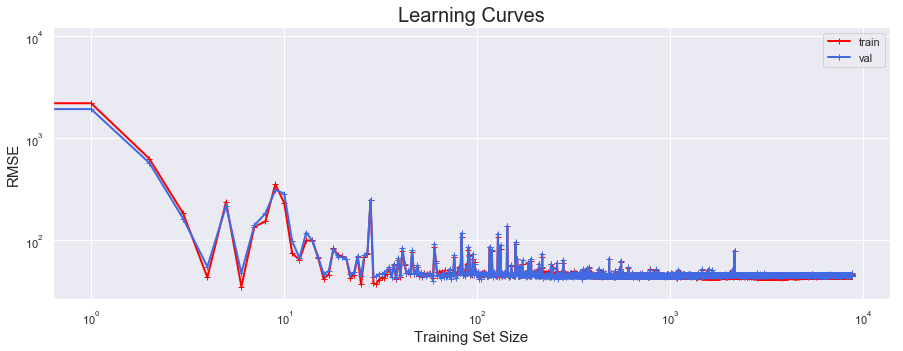

In [17]:
X_cols = ['overall_rank', 'humidity', 'Gender_M', 'Gender_F', 'gender_rank', 'division_rank']

sdg_reg = SGDRegressor(random_state=11,
                       penalty='l2', 
                       learning_rate='optimal',
                       fit_intercept=False,
                       alpha=0.05)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
# Fit to data and predict using pipelined scaling and SGDRegressor.
std_sdg_reg = make_pipeline(StandardScaler(), sdg_reg)          
r2_squared, RMSE, residuals, predictions = model_results(sdg_reg, X_train, y_train.values.ravel(), 
                                                         X_val, y_val.values.ravel())
r2_results.append(round(r2_squared, 2))
rmse_results.append(round(RMSE,2))
minutes.append(round(RMSE/60,2))

print('Results:')
print(f'R^2: {r2_squared}', f'RMSE: {RMSE}', f'Minutes: {RMSE/60}')
plot_learning_curves(sdg_reg, X_train, y_train.values.ravel(), X_val, y_val);

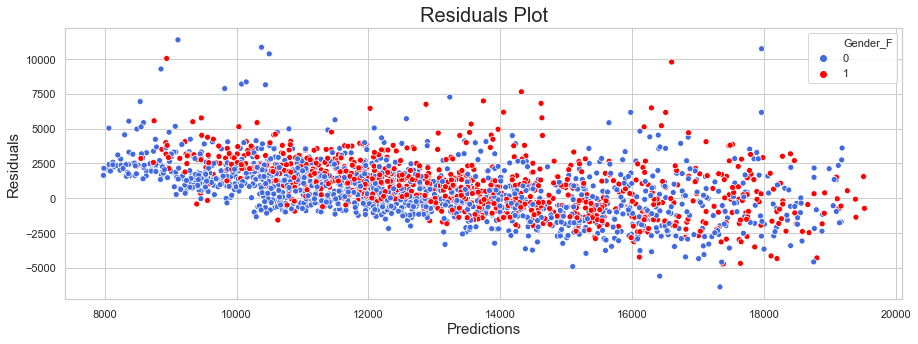

In [18]:
residuals_plot(predictions, residuals, X_val)

## Visualize the results in a dataframe and a graph

In [34]:
results_df = pd.DataFrame({'Model': models, 
                           'R^2': r2_results, 
                           'RMSE': rmse_results, 
                           'Minutes': minutes})


pd.options.display.float_format = '{:.2f}'.format
results_df

,Model,R^2,RMSE,Minutes
0,LinearRegression,0.66,1426.35,23.77
1,LinearRegressionCV,0.68,1383.42,23.06
2,SGDRegressor_NoPenalty,-1828885615612906868135952384.00,105132219080049984.00,1752203651334166.75
3,SGDRegressor_NoPenalty_Limit_X,0.63,1486.79,24.78
4,SGDRegressor_NoPenalty_Scaled,0.65,1458.81,24.31
5,SGDRegressor_LASSO,0.65,1463.54,24.39
6,SGDRegressor_RIDGE,0.31,2035.24,33.92


In [ ]:
# # plt.figure(figsize=(8,4))
# plt.plot(range(1,8), results_df['RMSE'], 'o-', color='red')
# plt.plot(range(1,8), results_df['R^2'], 'o-', color='blue')
# plt.title('Metrics', size=15)
# # plt.xlabel('Model', size=15)
# plt.ylabel('R^2                    RMSE', size=15)
# plt.xticks(range(1,8),['LinReg', 'LinRegCV', 'SGD', 'SGD_LimX', 'SGD_Std', 'SGD_Lasso', 'SGD_Ridge'],rotation=45)
# # plt.xticks(range(len(t12)), t11, size='small')

# plt.yscale('symlog');

## Run the final test data on the model that achieved the best results

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)
# X, y = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])

lin_reg = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 100)
r2_mean = np.mean(cross_val_score(lin_reg, X_test, y_test, cv=kf, scoring='r2'))
print('R^2: ', r2_mean)
nmse = np.mean(cross_val_score(lin_reg, X_test, y_test, cv=kf, scoring='neg_mean_squared_error'))
RMSE = np.sqrt(-nmse)
print('RMSE: ', RMSE, f'--> (Minutes {np.sqrt(-nmse)/60})')


R^2:  0.6933928548547353
RMSE:  1353.8138363096336 --> (Minutes 22.563563938493893)


### Find the results of one legacy runner to predict the finish time

In [27]:
df_all[df_all['Name'].str.contains('De La Via, Claudia')].values

array([[8341, 'De La Via, Claudia', 32, 0.2459959865207679,
        0.10398396391881734, 0.17345193294560382, 3.24, 73, 0.24, 22, 1,
        0, 13432.0]], dtype=object)

In [28]:
X_cols = ['Bib', 'Age', 'overall_rank', 'gender_rank', 'division_rank', 
          'pace_rate', 'temp', 'humidity', 'wind', 'Gender_F', 'Gender_M']


X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)

linreg_model = LinearRegression(fit_intercept=False)
r2_squared, RMSE, residuals, predictions = model_results(linreg_model, X_train, y_train, X_val, y_val)


print('Results:')
print(f'R^2: {r2_squared}', f'RMSE: {RMSE}', f'(Minutes: {RMSE/60})')
# plot_learning_curves(linreg_model, X_train, y_train, X_val, y_val);

Results:
R^2: 0.663361068190382 RMSE: 1426.3454771997237 (Minutes: 23.772424619995395)


In [29]:
X_cols = ['Bib', 'Age', 'overall_rank', 'gender_rank', 'division_rank', 
          'pace_rate', 'temp', 'humidity', 'wind', 'Gender_F', 'Gender_M']
claudia = df_all[df_all['Name'].str.contains('De La Via, Claudia')][X_cols].values

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_all, X_cols)

linreg_model = LinearRegression(fit_intercept=False)
linreg_model.fit(X_test, y_test)
claudia_prediction = linreg_model.predict(claudia)
claudia_prediction

array([[12174.46857285]])

In [30]:
# Claudia actual time
13432.0/3600   #3:43:52 -> 3:20:57

3.7311111111111113

In [31]:
# Claudia predicted time in hours
claudia_prediction[0,0]/3600

3.3817968257903495

In [32]:
# minutes
0.73111*60 - 0.38179*60

20.959200000000003

In [33]:
# seconds
0.9592*60

57.55200000000001